# Batch ETL Pipeline and Task Scheduler Orchestration (On-Premise)

## Notes

In [ ]:
from IPython.display import Image, display
display(Image("images/de_process_flow.png"))
display(Image("images/staging.png"))
display(Image("images/schematypes.png"))
display(Image("images/datapipeline.png"))

## Libraries and Dependencies

In [24]:
# Import necessary dependencies
import pandas as pd
import gdown
import tempfile
import shutil
import os
from dotenv import load_dotenv
load_dotenv()
#import psycopg2
from psycopg2 import sql
from sqlalchemy import create_engine, Column, Integer, String, Float, BigInteger, Text, TIMESTAMP, ForeignKey, MetaData, Table

import io
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

## Case Study - On-Premises -Azure Blob Storage

### Dataset & Data Architecture
- [Azure: zikologistics dataset]("https://drive.google.com/file/d/1O-wEH1FYyeAE3hygOUjmso0GgaOIsAVm/view?usp=drive_link")
- [Spark: nugabank dataset]("https://drive.google.com/file/d/1bHbh1M5cExdzwhzSaHNUVz3s9Jxtm2E5/view?usp=sharing)

In [ ]:
display(Image("images/data architecture.png"))

### Extraction Layer
- Download CSV content from Google Drive into a temporary file path 

In [2]:
with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as tmp:
    temp_path = tmp.name

file_id = "1O-wEH1FYyeAE3hygOUjmso0GgaOIsAVm"
gdown.download(f"https://drive.google.com/uc?id={file_id}", temp_path, quiet=False)
#shutil.copy(temp_path, "ziko_logistics.csv") # Save a permanent copy of the downloaded CSV

ziko_df = pd.read_csv(temp_path)
display(ziko_df.head(3))

# Clean up the temporary file
os.remove(temp_path)

Downloading...
From: https://drive.google.com/uc?id=1O-wEH1FYyeAE3hygOUjmso0GgaOIsAVm
To: C:\Users\Probook\AppData\Local\Temp\tmpm73bzoqp.csv
100%|██████████| 267k/267k [00:00<00:00, 3.38MB/s]


,Transaction_ID,Date,Customer_ID,Product_ID,Quantity,Unit_Price,Total_Cost,Discount_Rate,Sales_Channel,Order_Priority,...,Return_Reason,Payment_Type,Taxable,Region,Country,Customer_Name,Customer_Phone,Customer_Email,Customer_Address,Product_List_Title
0,200,2020-01-01 20:32:25.945945945,1086,536,3,120.436821,8265.374549,0.20,Online,High,...,Wrong Item,Wire Transfer,False,West,Canada,Customer 200,+1-652-572-9306,customer.200.78@example.com,"275 Second St, Phoenix, USA",Product 53
1,321,2020-01-02 06:55:08.108108108,1078,523,6,475.724994,4047.850479,NaN,Reseller,Critical,...,Damaged,PayPal,True,South,Mexico,Customer 321,+1-311-186-5760,customer.321.13@sample.com,"478 Third St, New York, USA",Product 33
2,989,2020-01-06 08:12:58.378378378,1077,535,3,146.400556,NaN,0.05,Direct,Critical,...,Damaged,PayPal,True,West,Canada,Customer 989,+1-922-606-9032,customer.989.99@example.com,"843 Second St, Phoenix, USA",Product 6


### Transformation Layer

In [3]:
print(ziko_df.columns)
display(ziko_df.info())

Index(['Transaction_ID', 'Date', 'Customer_ID', 'Product_ID', 'Quantity',
       'Unit_Price', 'Total_Cost', 'Discount_Rate', 'Sales_Channel',
       'Order_Priority', 'Warehouse_Code', 'Ship_Mode', 'Delivery_Status',
       'Customer_Satisfaction', 'Item_Returned', 'Return_Reason',
       'Payment_Type', 'Taxable', 'Region', 'Country', 'Customer_Name',
       'Customer_Phone', 'Customer_Email', 'Customer_Address',
       'Product_List_Title'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Transaction_ID         1005 non-null   int64  
 1   Date                   1005 non-null   object 
 2   Customer_ID            1005 non-null   int64  
 3   Product_ID             1005 non-null   int64  
 4   Quantity               1005 non-null   int64  
 5   Unit_Price             904 non-null    float64
 6   T

None

#### Data Modelling with storage into Azure

Fact Table: fact_sales
Captures transactional and measurable data:
| Column                  | Type    | Notes                            |
| ----------------------- | ------- | -------------------------------- |
| `transaction_id`        | PK      | Primary key                      |
| `date`                  | FK      | → `dim_date.date`                |
| `customer_id`           | FK      | → `dim_customer.customer_id`     |
| `product_id`            | FK      | → `dim_product.product_id`       |
| `warehouse_code`        | FK      | → `dim_warehouse.warehouse_code` |
| `payment_type`          | FK      | → `dim_payment.payment_type`     |
| `quantity`              | Integer | Metric                           |
| `unit_price`            | Float   | Metric                           |
| `total_cost`            | Float   | Metric                           |
| `discount_rate`         | Float   | Metric                           |
| `taxable`               | Boolean | Metric                           |
| `customer_satisfaction` | String  | Could be moved to attribute dim  |
| `item_returned`         | Boolean | Metric                           |


Dimension Tables
dim_customer
| Column             | Type   |
| ------------------ | ------ |
| `customer_id`      | PK     |
| `customer_name`    | String |
| `customer_email`   | String |
| `customer_phone`   | String |
| `customer_address` | String |
| `region`           | String |
| `country`          | String |

dim_product
| Column               | Type   |
| -------------------- | ------ |
| `product_id`         | PK     |
| `product_list_title` | String |

dim_warehouse
| Column            | Type   |
| ----------------- | ------ |
| `warehouse_code`  | PK     |
| `ship_mode`       | String |
| `delivery_status` | String |

dim_payment
| Column         | Type |
| -------------- | ---- |
| `payment_type` | PK   |

dim_order
| Column           | Type               |
| ---------------- | ------------------ |
| `transaction_id` | PK (or FK to fact) |
| `sales_channel`  | String             |
| `order_priority` | String             |
| `return_reason`  | String             |

Optional — if sales channel and priority have analytical value.

dim_date
| Column                                        | Type |
| --------------------------------------------- | ---- |
| `date`                                        | PK   |
| Add year, month, etc. for hierarchy if needed |      |


#### Cleaning and transformation

In [4]:
# Step 1: Handle missing values
df = ziko_df.copy()
df.fillna({
    "Unit_Price": df["Unit_Price"].mean(),
    "Total_Cost": df["Total_Cost"].mean(),
    "Discount_Rate": 0.0,
    "Return_Reason": "Unknown"
}, inplace=True)
df.head(3)

,Transaction_ID,Date,Customer_ID,Product_ID,Quantity,Unit_Price,Total_Cost,Discount_Rate,Sales_Channel,Order_Priority,...,Return_Reason,Payment_Type,Taxable,Region,Country,Customer_Name,Customer_Phone,Customer_Email,Customer_Address,Product_List_Title
0,200,2020-01-01 20:32:25.945945945,1086,536,3,120.436821,8265.374549,0.20,Online,High,...,Wrong Item,Wire Transfer,False,West,Canada,Customer 200,+1-652-572-9306,customer.200.78@example.com,"275 Second St, Phoenix, USA",Product 53
1,321,2020-01-02 06:55:08.108108108,1078,523,6,475.724994,4047.850479,0.00,Reseller,Critical,...,Damaged,PayPal,True,South,Mexico,Customer 321,+1-311-186-5760,customer.321.13@sample.com,"478 Third St, New York, USA",Product 33
2,989,2020-01-06 08:12:58.378378378,1077,535,3,146.400556,5096.553818,0.05,Direct,Critical,...,Damaged,PayPal,True,West,Canada,Customer 989,+1-922-606-9032,customer.989.99@example.com,"843 Second St, Phoenix, USA",Product 6


In [5]:
# Step 2: Normalize columns — cast to correct types
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Convert all object-type columns to lowercase strings (where applicable)
df = df.apply(lambda col: col.str.lower() if col.dtype == "object" else col)

# clean column names to snake_case if needed
#df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head(3)  

,Transaction_ID,Date,Customer_ID,Product_ID,Quantity,Unit_Price,Total_Cost,Discount_Rate,Sales_Channel,Order_Priority,...,Return_Reason,Payment_Type,Taxable,Region,Country,Customer_Name,Customer_Phone,Customer_Email,Customer_Address,Product_List_Title
0,200,2020-01-01 20:32:25.945945945,1086,536,3,120.436821,8265.374549,0.20,online,high,...,wrong item,wire transfer,False,west,canada,customer 200,+1-652-572-9306,customer.200.78@example.com,"275 second st, phoenix, usa",product 53
1,321,2020-01-02 06:55:08.108108108,1078,523,6,475.724994,4047.850479,0.00,reseller,critical,...,damaged,paypal,True,south,mexico,customer 321,+1-311-186-5760,customer.321.13@sample.com,"478 third st, new york, usa",product 33
2,989,2020-01-06 08:12:58.378378378,1077,535,3,146.400556,5096.553818,0.05,direct,critical,...,damaged,paypal,True,west,canada,customer 989,+1-922-606-9032,customer.989.99@example.com,"843 second st, phoenix, usa",product 6


#### Step 3: Create Dimension Tables

In [6]:
dim_customer = df[[
    "Customer_ID", "Customer_Name", "Customer_Phone", "Customer_Email",
    "Customer_Address", "Region", "Country"
]].drop_duplicates(subset=["Customer_ID"]).reset_index(drop=True)


dim_customer.head(3)

,Customer_ID,Customer_Name,Customer_Phone,Customer_Email,Customer_Address,Region,Country
0,1086,customer 200,+1-652-572-9306,customer.200.78@example.com,"275 second st, phoenix, usa",west,canada
1,1078,customer 321,+1-311-186-5760,customer.321.13@sample.com,"478 third st, new york, usa",south,mexico
2,1077,customer 989,+1-922-606-9032,customer.989.99@example.com,"843 second st, phoenix, usa",west,canada


In [7]:
dim_product = df[[
    "Product_ID", "Product_List_Title"
]].drop_duplicates(subset=["Product_ID"]).reset_index(drop=True)
dim_product.head()

,Product_ID,Product_List_Title
0,536,product 53
1,523,product 33
2,535,product 6
3,546,product 68
4,556,product 89


In [8]:
dim_warehouse = df[[
    "Warehouse_Code", "Ship_Mode", "Delivery_Status"]].drop_duplicates(subset=["Warehouse_Code"]).reset_index(drop=True)

dim_warehouse["Warehouse_ID"] = dim_warehouse.index + 1
dim_warehouse = dim_warehouse[["Warehouse_ID", "Warehouse_Code", "Ship_Mode", "Delivery_Status"]]

dim_warehouse.head()   

,Warehouse_ID,Warehouse_Code,Ship_Mode,Delivery_Status
0,1,wh-3,2-day,cancelled
1,2,wh-1,overnight,backorder
2,3,wh-2,2-day,delivered


In [9]:
dim_payment = df[["Payment_Type"]].drop_duplicates().reset_index(drop=True)
dim_payment["Payment_ID"] = dim_payment.index + 1
dim_payment = dim_payment[["Payment_ID", "Payment_Type"]]

dim_payment.head()     

,Payment_ID,Payment_Type
0,1,wire transfer
1,2,paypal
2,3,cash
3,4,credit card


In [10]:
dim_order = df[[
    "Transaction_ID", "Sales_Channel", "Order_Priority", "Taxable",
    "Item_Returned", "Return_Reason", "Customer_Satisfaction"
]].drop_duplicates(subset=["Transaction_ID"]).reset_index(drop=True)

dim_order.head()

,Transaction_ID,Sales_Channel,Order_Priority,Taxable,Item_Returned,Return_Reason,Customer_Satisfaction
0,200,online,high,False,False,wrong item,neutral
1,321,reseller,critical,True,True,damaged,satisfied
2,989,direct,critical,True,True,damaged,unsatisfied
3,682,reseller,medium,True,False,wrong item,unsatisfied
4,484,direct,low,False,True,late,satisfied


In [11]:
dim_date = df[["Date"]].drop_duplicates().reset_index(drop=True)
dim_date["Date_ID"] = dim_date.index + 1
dim_date = dim_date[["Date_ID", "Date"]]

dim_date.head()  

,Date_ID,Date
0,1,2020-01-01 20:32:25.945945945
1,2,2020-01-02 06:55:08.108108108
2,3,2020-01-06 08:12:58.378378378
3,4,2020-01-07 22:03:14.594594594
4,5,2020-01-07 07:08:06.486486486


In [12]:
# Derived Metrics
df["Revenue"] = df["Quantity"] * df["Unit_Price"]
df["Discount_Amount"] = df["Revenue"] * df["Discount_Rate"]
df["Net_Revenue"] = df["Revenue"] - df["Discount_Amount"]
df["Profit"] = df["Net_Revenue"] - df["Total_Cost"]

df[["Revenue", "Discount_Amount", "Net_Revenue", "Unit_Price", "Total_Cost", "Profit"]] = \
    df[["Revenue", "Discount_Amount", "Net_Revenue","Unit_Price" , "Total_Cost", "Profit"]].round(2)


#### Step 4: Build Fact Table

In [13]:
fact_sales = df \
    .merge(dim_customer[["Customer_ID"]], on="Customer_ID", how="left") \
    .merge(dim_product[["Product_ID"]], on="Product_ID", how="left") \
    .merge(dim_warehouse, on=["Warehouse_Code"], how="left") \
    .merge(dim_payment, on="Payment_Type", how="left") \
    .merge(dim_order[["Transaction_ID"]], on="Transaction_ID", how="left") \
    .merge(dim_date, on="Date", how="left")

fact_sales = fact_sales[[  
    "Transaction_ID",      # (natural key)
    "Date_ID",
    "Customer_ID",
    "Product_ID",
    "Warehouse_ID",
    "Payment_ID",

    # Measures
    "Quantity",
    "Unit_Price",
    "Total_Cost",
    "Revenue",
    "Discount_Amount",
    "Net_Revenue",        
    "Profit"           
]]

# Optional: clean column names to snake_case if needed
#fact_sales.columns = fact_sales.columns.str.lower().str.replace(" ", "_")
display(fact_sales.head())
print("✅ Data cleaned and transformed.")

,Transaction_ID,Date_ID,Customer_ID,Product_ID,Warehouse_ID,Payment_ID,Quantity,Unit_Price,Total_Cost,Revenue,Discount_Amount,Net_Revenue,Profit
0,200,1,1086,536,1,1,3,120.44,8265.37,361.31,72.26,289.05,-7976.33
1,321,2,1078,523,2,2,6,475.72,4047.85,2854.35,0.00,2854.35,-1193.50
2,989,3,1077,535,2,2,3,146.40,5096.55,439.20,21.96,417.24,-4679.31
3,682,4,1027,546,2,3,6,19.37,8194.28,116.24,0.00,116.24,-8078.04
4,484,5,1052,556,3,3,8,193.22,8331.33,1545.77,309.15,1236.62,-7094.71


✅ Data cleaned and transformed.


### Loading Layer using columnar packages

#### Storage in Azure Blob Storage

visit azure portal:  
- create subscription
- create resource group (RG) in subscription
- create storage account in RG (LRS)
- in storage account, create a container
- get acces key connection string and container name

#### Set up a connection to azure blob storage

In [14]:
# Set up a connection to azure blob storage
connection_string = os.getenv("ZIKO_AZURE_STORAGE_CONNECTION_STRING")
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

container_name = os.getenv("ziko_container_name")
container_client = blob_service_client.get_container_client(container_name)

#### Load data into azure storage blob uing parquet file

In [22]:
# create a function to upload a DataFrame to Azure Blob Storage

def upload_dataframe_to_blob(df, container_name, blob_name, table_name):
    # Convert DataFrame to Parquet format
    buffer = io.BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)  # Reset buffer position to the beginning

    # Upload to Azure Blob Storage
    blob_client = container_client.get_blob_client(blob_name)
    blob_client.upload_blob(buffer, overwrite=True)
    print(f"✅ Table '{table_name}' uploaded to '{container_name}/{blob_name}' with {df.shape[0]} rows.")   
    

In [23]:
# Load the DataFrames to Azure Blob Storage
upload_dataframe_to_blob(dim_customer, container_name, "rawdata/dim_customer.parquet", "dim_customer")
upload_dataframe_to_blob(dim_product, container_name, "rawdata/dim_product.parquet", "dim_product")
upload_dataframe_to_blob(dim_warehouse, container_name, "rawdata/dim_warehouse.parquet", "dim_warehouse")
upload_dataframe_to_blob(dim_payment, container_name, "rawdata/dim_payment.parquet", "dim_payment")
upload_dataframe_to_blob(dim_order, container_name, "rawdata/dim_order.parquet", "dim_order")
upload_dataframe_to_blob(dim_date, container_name, "rawdata/dim_date.parquet", "dim_date")
upload_dataframe_to_blob(fact_sales, container_name, "rawdata/fact_sales.parquet", "fact_sales")


# Display confirmation message
print(f"\n ✅ All DataFrames uploaded successfully to Azure Blob Storage Container: {container_name}.")

✅ Table 'dim_customer' uploaded to 'zikologisticscontainer/rawdata/dim_customer.parquet' with 100 rows.
✅ Table 'dim_product' uploaded to 'zikologisticscontainer/rawdata/dim_product.parquet' with 60 rows.
✅ Table 'dim_warehouse' uploaded to 'zikologisticscontainer/rawdata/dim_warehouse.parquet' with 3 rows.
✅ Table 'dim_payment' uploaded to 'zikologisticscontainer/rawdata/dim_payment.parquet' with 4 rows.
✅ Table 'dim_order' uploaded to 'zikologisticscontainer/rawdata/dim_order.parquet' with 1000 rows.
✅ Table 'dim_date' uploaded to 'zikologisticscontainer/rawdata/dim_date.parquet' with 615 rows.
✅ Table 'fact_sales' uploaded to 'zikologisticscontainer/rawdata/fact_sales.parquet' with 1005 rows.

 ✅ All DataFrames uploaded successfully to Azure Blob Storage Container: zikologisticscontainer.


### Create a ETL Pipeline automation
- create a py file using all steps above
- open task scheduler on windows : create a task and set run time; specify python.exe, .py to run and location of .py file
- enable task

## Case Study 2 : PYSPARK

### Load Libraries

In [1]:
# import libraries
from IPython.display import Image, display
from pyspark.sql import SparkSession, DataFrameWriter
from pyspark.sql.functions import monotonically_increasing_id
import os
import psycopg2
from dotenv import load_dotenv
load_dotenv()
from urllib.parse import urlparse
import gdown

In [2]:
## Initiate Spark Session
spark = SparkSession.builder \
    .appName("pyspark batch case study") \
    .getOrCreate()
spark


### Extraction Layer

In [3]:
# Download CSV content from Google Drive into a temporary file path 
'''
with tempfile.NamedTemporaryFile(delete=False, suffix=".csv") as tmp:
    temp_path = tmp.name

file_id = "1WvnxUWIUQcRSXB5so7-PoGPxU9ekSkYb"
gdown.download(f"https://drive.google.com/uc?id={file_id}", temp_path, quiet=False)

shutil.copy(temp_path, "nuga_bank_transactions.csv") # Save a permanent copy of the downloaded CSV

nuga_bank_df = spark.read.csv(temp_path, header=True, inferSchema=True) # Load into Spark

nuga_bank_df.cache()  # Force read and keep in memory
nuga_bank_df.count()  # Triggers actual file read
os.remove(temp_path) # delete temp file
'''

df = spark.read.csv(r'D:\Portfolio\my_projects\DataEngineering\PySpark\nuga_bank_transactions.csv', header=True, inferSchema=True)

In [4]:
print(f"Data Shape: {df.count()} rows × {len(df.columns)} columns")
df.show(5)

Data Shape: 1000000 rows × 23 columns
+--------------------+------+----------------+--------------+--------------------+------------------+--------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+-------------+-------------+--------+-----+---------+--------------------+--------------------+------+--------------+
|    Transaction_Date|Amount|Transaction_Type| Customer_Name|    Customer_Address|     Customer_City|Customer_State|    Customer_Country|             Company|           Job_Title|               Email|       Phone_Number|Credit_Card_Number|                IBAN|Currency_Code|Random_Number|Category|Group|Is_Active|        Last_Updated|         Description|Gender|Marital_Status|
+--------------------+------+----------------+--------------+--------------------+------------------+--------------+--------------------+--------------------+--------------------+--------------------+------

In [5]:
df.printSchema()

root
 |-- Transaction_Date: timestamp (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Customer_Address: string (nullable = true)
 |-- Customer_City: string (nullable = true)
 |-- Customer_State: string (nullable = true)
 |-- Customer_Country: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Phone_Number: string (nullable = true)
 |-- Credit_Card_Number: long (nullable = true)
 |-- IBAN: string (nullable = true)
 |-- Currency_Code: string (nullable = true)
 |-- Random_Number: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- Group: string (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Last_Updated: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Marital_Status: string (nullable = true)

### Data Cleaning and Modelling

In [6]:
# Checking for null values
for col in df.columns:
      print(col, 'Nulls: ' ,df.filter(df[col].isNull()).count() )


Transaction_Date Nulls:  0
Amount Nulls:  0
Transaction_Type Nulls:  0
Customer_Name Nulls:  100425
Customer_Address Nulls:  100087
Customer_City Nulls:  100034
Customer_State Nulls:  100009
Customer_Country Nulls:  100672
Company Nulls:  100295
Job_Title Nulls:  99924
Email Nulls:  100043
Phone_Number Nulls:  100524
Credit_Card_Number Nulls:  100085
IBAN Nulls:  100300
Currency_Code Nulls:  99342
Random_Number Nulls:  99913
Category Nulls:  100332
Group Nulls:  100209
Is_Active Nulls:  100259
Last_Updated Nulls:  100321
Description Nulls:  100403
Gender Nulls:  99767
Marital_Status Nulls:  99904


In [7]:
df.describe().show()

+-------+------------------+----------------+-------------+--------------------+-------------+--------------+----------------+-------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------+------------------+--------+------+---------+--------------------+------+--------------+
|summary|            Amount|Transaction_Type|Customer_Name|    Customer_Address|Customer_City|Customer_State|Customer_Country|      Company|         Job_Title|              Email|        Phone_Number|  Credit_Card_Number|                IBAN|Currency_Code|     Random_Number|Category| Group|Is_Active|         Description|Gender|Marital_Status|
+-------+------------------+----------------+-------------+--------------------+-------------+--------------+----------------+-------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------+------------------+--------+------+---------+---------

In [8]:
# 1. Handle null
df_clean = df.fillna ({
    "Customer_Name": "Unknown",
    "Customer_Address": "Unknown",
    "Customer_City": "Unknown",
    "Customer_State": "Unknown",
    "Customer_Country": "Unknown",
    "Email": "unknown@example.com",
    "Phone_Number": "Unknown",
    "Company": "Undisclosed",
    "Job_Title": "Unemployed",
    "Currency_Code": "N/A",
    "Category": "N/A",
    "Group": "N/A",
    "Is_Active": "Unknown",
    "Description": "No description provided",
    "Gender": "Unspecified",
    "Marital_Status": "Unspecified",
    "IBAN": "Unknown",
    "Random_Number": -1.0,
    "Credit_Card_Number": 0 
  #  "Last_Updated": "1900-01-01"
})

In [9]:
# Drop last updated null rows
df_clean = df_clean.na.drop(subset=["Last_Updated"])

In [10]:
# Checking for null values again
for col in df_clean.columns:
    null_count = df_clean.filter(df_clean[col].isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} nulls")
print(f"All null values handled: \n New Data Shape: {df_clean.count()} rows × {len(df_clean.columns)} columns")

All null values handled: 
 New Data Shape: 899679 rows × 23 columns


In [11]:
#  Convert all column names to lowercase
from pyspark.sql.functions import col
df_clean = df_clean.select([col(c).alias(c.lower()) for c in df_clean.columns])

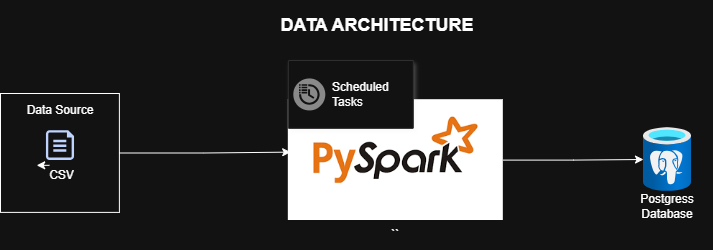

In [12]:
display(Image("sparkpsql.png"))

### Transformation Layer

In [13]:
transaction = df_clean \
    .select('transaction_date',  'amount','transaction_type','description') \
    .distinct() \
    .withColumn("transaction_id", monotonically_increasing_id()).cache()
transaction = transaction.select('transaction_id','transaction_date',  'amount','transaction_type','description')
print(transaction.printSchema())
transaction.show()

root
 |-- transaction_id: long (nullable = false)
 |-- transaction_date: timestamp (nullable = true)
 |-- amount: double (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- description: string (nullable = false)

None
+--------------+--------------------+------+----------------+--------------------+
|transaction_id|    transaction_date|amount|transaction_type|         description|
+--------------+--------------------+------+----------------+--------------------+
|             0|2024-04-09 03:24:...|476.48|      Withdrawal|No description pr...|
|             1|2024-03-30 05:54:...|886.65|      Withdrawal|Boy artist genera...|
|             2|2024-01-31 18:09:...|755.02|         Deposit|Least claim remai...|
|             3|2024-01-02 16:16:...| 820.0|         Deposit|Measure season ta...|
|             4|2024-04-03 03:58:...|926.21|      Withdrawal|Born plan after f...|
|             5|2024-01-10 00:17:...|757.12|         Deposit|Morning change ar...|
|             6|

In [14]:
customer = df_clean \
    .select('customer_name', 'customer_address', 'customer_city', 'customer_state', 'customer_country') \
    .distinct() \
    .withColumn("customer_id", monotonically_increasing_id()).cache()
customer =customer.select('customer_id','customer_name', 'customer_address', 'customer_city', 'customer_state','customer_country')
print(customer.printSchema())
customer.show()

root
 |-- customer_id: long (nullable = false)
 |-- customer_name: string (nullable = false)
 |-- customer_address: string (nullable = false)
 |-- customer_city: string (nullable = false)
 |-- customer_state: string (nullable = false)
 |-- customer_country: string (nullable = false)

None
+-----------+--------------------+--------------------+------------------+--------------+-------------------+
|customer_id|       customer_name|    customer_address|     customer_city|customer_state|   customer_country|
+-----------+--------------------+--------------------+------------------+--------------+-------------------+
|          0| Dr. Steven Sandoval|71969 Casey Mountain|North Belindaville|     Wisconsin|            Uruguay|
|          1|         Jamie Dixon|0146 Veronica Mou...|         Jonesland|      Delaware|       Saint Martin|
|          2|         Amber Jones|37115 Peterson Vi...|    West Kellyside|      Delaware|            Unknown|
|          3|    Joseph Cervantes|59506 Christense

In [15]:
employee = df_clean \
    .select('company', 'job_title', 'email', 'phone_number','gender', 'marital_status') \
    .distinct() \
    .withColumn("employee_id", monotonically_increasing_id()).cache()

employee = employee.select('employee_id','company', 'job_title', 'email', 'phone_number','gender', 'marital_status')
print(employee.printSchema())
employee.show()

root
 |-- employee_id: long (nullable = false)
 |-- company: string (nullable = false)
 |-- job_title: string (nullable = false)
 |-- email: string (nullable = false)
 |-- phone_number: string (nullable = false)
 |-- gender: string (nullable = false)
 |-- marital_status: string (nullable = false)

None
+-----------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+
|employee_id|             company|           job_title|               email|        phone_number|     gender|marital_status|
+-----------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+
|          0|         Undisclosed|Sport and exercis...| unknown@example.com|    001-817-207-5116|       Male|        Single|
|          1|       Park and Sons|Race relations of...|   joy43@example.org|          4942627537|     Female|       Married|
|          2|       Walker-Hanson|      Hydrogeologist|mendozabrett@exa

In [16]:
# Build fact_transaction with LEFT JOINs to preserve as many rows as possible
fact_table = df_clean \
      .join(transaction,['transaction_date', 'amount','transaction_type', 'description'],'inner')\
      .join(customer, ['customer_name', 'customer_address', 'customer_city','customer_state', 'customer_country'],'inner')\
      .join(employee, ['company', 'job_title', 'email', 'phone_number','gender', 'marital_status'], 'inner') \
      .select('transaction_id','customer_id', 'employee_id','amount', 'credit_card_number', 'iban','currency_code', 'random_number',\
        'category', 'group','is_active','last_updated' )
print(fact_table.printSchema())
fact_table.show(5)

root
 |-- transaction_id: long (nullable = false)
 |-- customer_id: long (nullable = false)
 |-- employee_id: long (nullable = false)
 |-- amount: double (nullable = true)
 |-- credit_card_number: long (nullable = false)
 |-- iban: string (nullable = false)
 |-- currency_code: string (nullable = false)
 |-- random_number: double (nullable = false)
 |-- category: string (nullable = false)
 |-- group: string (nullable = false)
 |-- is_active: string (nullable = false)
 |-- last_updated: timestamp (nullable = true)

None
+--------------+-------------+-----------+------+------------------+--------------------+-------------+-------------+--------+-----+---------+--------------------+
|transaction_id|  customer_id|employee_id|amount|credit_card_number|                iban|currency_code|random_number|category|group|is_active|        last_updated|
+--------------+-------------+-----------+------+------------------+--------------------+-------------+-------------+--------+-----+---------+------

### Loading Layer

In [17]:
# connect to db
def get_db_connection(db_url):
    conn = psycopg2.connect(db_url)
    print("✅ Database connected successfully.")
    return conn

In [18]:
db_url = os.getenv("NUGA_BANK") 
conn = get_db_connection(db_url)

✅ Database connected successfully.


In [19]:
# Create a function to create all tables
def create_tables(db_url):
    conn = get_db_connection(db_url)
    cursor = conn.cursor()

    create_table_query = '''
        DROP TABLE IF EXISTS fact_table;
        DROP TABLE IF EXISTS employee;
        DROP TABLE IF EXISTS transaction;
        DROP TABLE IF EXISTS customer;

        CREATE TABLE customer (
            customer_id BIGINT PRIMARY KEY,
            customer_name TEXT NOT NULL,
            customer_address TEXT NOT NULL,
            customer_city TEXT NOT NULL,
            customer_state TEXT NOT NULL,
            customer_country TEXT NOT NULL
        );

        CREATE TABLE transaction (
            transaction_id BIGINT PRIMARY KEY,
            transaction_date TIMESTAMP NOT NULL,
            amount FLOAT NOT NULL,
            transaction_type TEXT NOT NULL,
            description TEXT NOT NULL
        );

        CREATE TABLE employee (
            employee_id BIGINT PRIMARY KEY,
            company TEXT NOT NULL,
            job_title TEXT NOT NULL,
            email TEXT NOT NULL,
            phone_number TEXT NOT NULL,
            gender TEXT NOT NULL,
            marital_status TEXT NOT NULL
        );

        CREATE TABLE fact_table (
            transaction_id BIGINT REFERENCES transaction(transaction_id) ON DELETE CASCADE,
            customer_id BIGINT REFERENCES customer(customer_id) ON DELETE CASCADE,
            employee_id BIGINT REFERENCES employee(employee_id) ON DELETE CASCADE,
            amount FLOAT NOT NULL,
            credit_card_number BIGINT NOT NULL,
            iban TEXT NOT NULL,
            currency_code VARCHAR(10) NOT NULL,
            random_number FLOAT NOT NULL,
            category TEXT NOT NULL,
            "group" TEXT NOT NULL, -- group is a reserved word
            is_active TEXT NOT NULL,
            last_updated TIMESTAMP NOT NULL
        );
    '''

    cursor.execute(create_table_query)
    conn.commit()
    print("✅ All tables created successfully.")
    cursor.close()
    conn.close()


In [20]:
create_tables(db_url)

✅ Database connected successfully.
✅ All tables created successfully.


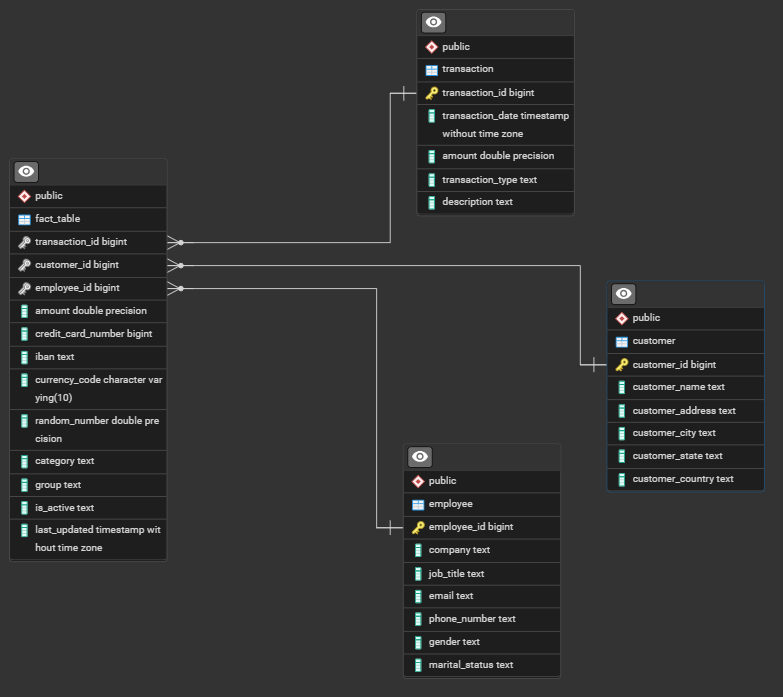

In [55]:
display(Image("sparkerd.png"))

In [27]:
# Define JDBC Settings
parsed = urlparse(db_url);\
jdbc_url = f"jdbc:postgresql://{parsed.hostname}:{parsed.port}{parsed.path}";\
jdbc_props= {"user": parsed.username, "password": parsed.password, "driver": "org.postgresql.Driver"}
print(f"jdbc connection: {jdbc_url}")

jdbc connection: jdbc:postgresql://localhost:5432/nuga_spark_db


In [25]:
# 3. Create a Write Function
def write_to_postgres(df, table_name, jdbc_url, jdbc_props, mode="append"):
    try:
        print(f"📝 Writing table: {table_name} ({df.count()} rows)...")
        df.write.jdbc(
            url=jdbc_url,
            table=table_name,
            mode=mode,
            properties=jdbc_props
        )
        print(f"✅ Successfully wrote: {table_name}")
        
    except Exception as e:
        print(f"❌ Failed to write table: {table_name}")
        print(f"Error: {str(e)}")


In [26]:
write_to_postgres(transaction,"transaction",jdbc_url,jdbc_props)
write_to_postgres(customer,"customer",jdbc_url,jdbc_props)
write_to_postgres(employee,"employee",jdbc_url,jdbc_props)
write_to_postgres(fact_table,"fact_table",jdbc_url,jdbc_props)

📝 Writing table: transaction (899679 rows)...
✅ Successfully wrote: transaction
📝 Writing table: customer (899581 rows)...
✅ Successfully wrote: customer
📝 Writing table: employee (899550 rows)...
✅ Successfully wrote: employee
📝 Writing table: fact_table (899679 rows)...
✅ Successfully wrote: fact_table


In [29]:
# Display confirmation message
print(f"\n ✅ All DataFrames uploaded successfully to postgres db: {parsed.path}.")


 ✅ All DataFrames uploaded successfully to postgres db: /nuga_spark_db.


In [ ]:
# Stop existing session
spark.stop()

### Automate using task scheduler
 - convert notrbook to .py file
 - create task in task scheduler 
 - pip uninstall pyspark ; pip install pyspark==3.4.1 ; Java 8

